In [2]:
from argparse import Namespace
import jax.numpy as jnp
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import seaborn as sns

from jax.nn import softmax
from jax.config import config
from pathlib import Path
from collections import namedtuple

config.update('jax_platform_name', 'cpu')
np.set_printoptions(precision=4)
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams.update({'font.size': 18})

from grl.utils import load_info
from grl.utils.mdp import all_t_discounted_returns
from grl.utils.data import uncompress_episode_rewards
from grl.utils.loss import mse
from grl.environment import get_env

from definitions import ROOT_DIR

In [7]:
results_dir_td = Path(ROOT_DIR, 'results', 'popgym_sweep_td')
results_dir_mc = Path(ROOT_DIR, 'results', 'popgym_sweep_mc')
results_dir_split = Path(ROOT_DIR, 'results', 'rnn_split')

In [38]:
results_path = list(results_dir_mc.iterdir())[4]
info = load_info(results_path)

dict_to_test = info['episodes_info']['offline_eval']

In [39]:
import sys

def get_size(obj, seen=None):
    """Recursively finds size of objects"""
    size = sys.getsizeof(obj)
    if seen is None:
        seen = set()
    obj_id = id(obj)
    if obj_id in seen:
        return 0
    # Important mark as seen *before* entering recursion to gracefully handle
    # self-referential objects
    seen.add(obj_id)
    if isinstance(obj, dict):
        size += sum([get_size(v, seen) for v in obj.values()])
        size += sum([get_size(k, seen) for k in obj.keys()])
    elif hasattr(obj, '__dict__'):
        size += get_size(obj.__dict__, seen)
    elif hasattr(obj, '__iter__') and not isinstance(obj, (str, bytes, bytearray)):
        size += sum([get_size(i, seen) for i in obj])
    return size

print(f"{results_path.stem}: {get_size(dict_to_test) / 1000000:.2f}MB")

popgym-HigherLowerEasy-v0_seed(2022)_time(20230725-070842)_4cbc26107b65bb0a69aa3acbcac680f1: 0.42MB


In [6]:

offline_eval = []
all_results_paths = list(results_dir_td.iterdir()) + list(results_dir_mc.iterdir())
# all_results_paths = list(results_dir_td.iterdir())

# all_results_paths = list(results_dir_split.iterdir())

for results_path in tqdm(all_results_paths):
    if results_path.is_dir() or results_path.suffix != '.npy':
        continue
    
    info = load_info(results_path)
    args = Namespace(**info['args'])

    # if (args.multihead_loss_mode != 'both') and (args.multihead_lambda_coeff > 0.):
    #     continue

    no_gamma_terminal = not args.no_gamma_terminal

    offline_evals = info['episodes_info']['offline_eval']
    eval_freq = args.offline_eval_freq
    total_steps = args.total_steps
    env = get_env(args)
    if not hasattr(env, 'gamma'):
        env.gamma = args.gamma
    reward_scale = 1.
    normalize_rewards = args.normalize_rewards
    if args.normalize_rewards:
        assert hasattr(env, 'R_max') and hasattr(env, 'R_min')
        reward_scale = 1 / (env.R_max - env.R_min)


    all_t_undisc_returns = []

    # For each offline eval
    for i, oe in enumerate(offline_evals):
        d = {**info['args']}

        avg_undisc_returns = 0
        avg_value_err = 0

        # iterate through number of seeds
        for ep_rewards, ep_qs in zip(oe['episode_rewards'], oe['episode_qs']):
            # relevant qs are everything but the last index
            # b/c last index is terminal q
            relevant_ep_qs = ep_qs[:-1]

            episode_rewards = np.array(uncompress_episode_rewards(ep_rewards['episode_length'], ep_rewards['most_common_reward'], ep_rewards['compressed_rewards']))

            discounts = np.ones(episode_rewards.shape[0])
            if no_gamma_terminal:
                discounts *= env.gamma

            discounts[-1] = 0.

            discounted_returns = all_t_discounted_returns(discounts, reward_scale * episode_rewards)
            avg_value_err += mse(relevant_ep_qs, discounted_returns).item()

            # TODO: calculate value estimation error through q_t - g_t
            undisc_returns = episode_rewards.sum()
            avg_undisc_returns += undisc_returns

        avg_undisc_returns /= len(oe['episode_rewards'])
        avg_value_err /= len(oe['episode_rewards'])

        d['timestep'] = int(i * eval_freq)
        d['undisc_returns'] = avg_undisc_returns
        d['value_err'] = avg_value_err
    
        offline_eval.append(d)

all_res_df = pd.DataFrame(offline_eval)



  0%|          | 0/120 [00:00<?, ?it/s]

AttributeError: 'Namespace' object has no attribute 'gamma'

In [5]:
arch = "gru"
measure_col = 'undisc_returns'
all_args = list(info['args'].keys())

offline_eval_df = all_res_df[
    (all_res_df['arch'] == arch)
    & (all_res_df['multihead_lambda_coeff'] >= 0.)
#     & (all_res_df['multihead_lambda_coeff'] != 1.)
#     & (all_res_df['multihead_loss_mode'] != 'td')
#     & (all_res_df['multihead_action_mode'] == 'td')
]

unique_seeds = offline_eval_df.seed.unique()

split_by_args = ['spec', 'multihead_action_mode', 'multihead_loss_mode', 'multihead_lambda_coeff', 'lr']

# For split exp
# split_by_args = ['spec', 'multihead_loss_mode', 'lr']

rnn_grouped = offline_eval_df.groupby(split_by_args, as_index=False)

NameError: name 'all_res_df' is not defined

In [12]:
all_res_df

,spec,no_gamma_terminal,max_episode_steps,feature_encoding,algo,arch,epsilon,lr,optimizer,hidden_size,...,offline_eval_epsilon,checkpoint_freq,save_all_checkpoints,total_steps,platform,seed,study_name,timestep,undisc_returns,value_err
0,rocksample,False,1000,one_hot,multihead_rnn,gru,0.1,0.000001,adam,64,...,0.1,-1,False,1500000,cpu,2024,rnn_rocksample_sweep_td,0,-31.0,0.469165
1,rocksample,False,1000,one_hot,multihead_rnn,gru,0.1,0.000001,adam,64,...,0.1,-1,False,1500000,cpu,2024,rnn_rocksample_sweep_td,1000,0.0,0.116940
2,rocksample,False,1000,one_hot,multihead_rnn,gru,0.1,0.000001,adam,64,...,0.1,-1,False,1500000,cpu,2024,rnn_rocksample_sweep_td,2000,4.0,0.109426
3,rocksample,False,1000,one_hot,multihead_rnn,gru,0.1,0.000001,adam,64,...,0.1,-1,False,1500000,cpu,2024,rnn_rocksample_sweep_td,3000,-2.0,0.131880
4,rocksample,False,1000,one_hot,multihead_rnn,gru,0.1,0.000001,adam,64,...,0.1,-1,False,1500000,cpu,2024,rnn_rocksample_sweep_td,4000,7.0,0.130211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179995,rocksample,False,1000,one_hot,multihead_rnn,gru,0.1,0.000001,adam,64,...,0.1,-1,False,1500000,cpu,2020,rnn_rocksample_sweep_mc,1495000,14.0,0.045318
179996,rocksample,False,1000,one_hot,multihead_rnn,gru,0.1,0.000001,adam,64,...,0.1,-1,False,1500000,cpu,2020,rnn_rocksample_sweep_mc,1496000,18.0,0.034946
179997,rocksample,False,1000,one_hot,multihead_rnn,gru,0.1,0.000001,adam,64,...,0.1,-1,False,1500000,cpu,2020,rnn_rocksample_sweep_mc,1497000,15.0,0.027271
179998,rocksample,False,1000,one_hot,multihead_rnn,gru,0.1,0.000001,adam,64,...,0.1,-1,False,1500000,cpu,2020,rnn_rocksample_sweep_mc,1498000,12.0,0.016947


In [13]:
# take mean and std_err over mean over seeds
rnn_mean = rnn_grouped.mean(numeric_only=True)
rnn_sem = rnn_grouped.sem(numeric_only=True)

# Now we take the max over everything but learning rate
max_over_args = ['lr']
grouped_args = [arg for arg in split_by_args if arg not in max_over_args]
rnn_less_lr_grouped = rnn_mean.groupby(grouped_args, as_index=False)

rnn_arg_maxes = rnn_mean.sort_values(measure_col).drop_duplicates(grouped_args, keep='last')

In [14]:
# drop columns we need in original df
pruned_rnn_arg_maxes = rnn_arg_maxes.drop(columns=['timestep', 'seed'])

# A df of results over all the maxes.
max_offline_eval_df = pruned_rnn_arg_maxes.merge(offline_eval_df, on=split_by_args, how='inner')


In [35]:
w = 100
mode = 'same'
max_offline_eval_df[f'avged_returns'] = max_offline_eval_df.groupby(split_by_args)['undisc_returns_y'].transform(lambda x: np.convolve(x, np.ones(w), mode=mode) / w)

In [36]:
df = max_offline_eval_df
# pivot_value_key = 'undisc_returns_y'
pivot_value_key = 'avged_returns'

# pivot_value_key = 'value_err_y'


# df = offline_eval_df
# pivot_value_key = 'undisc_returns'

all_labels = \
    sorted(['_'.join([str(el) for el in row]) for row in df[[arg for arg in grouped_args if (arg != 'spec') and (arg != 'timestep')]]\
        .drop_duplicates()\
        .to_numpy()])

label_cmap = {}

color = iter(cm.tab10(np.linspace(0, 1, 10)))
for i in range(len(all_labels)):
    c = next(color)
    label_cmap[all_labels[i]] = c

In [1]:
all_labels

NameError: name 'all_labels' is not defined

  0%|          | 0/1 [00:00<?, ?it/s]

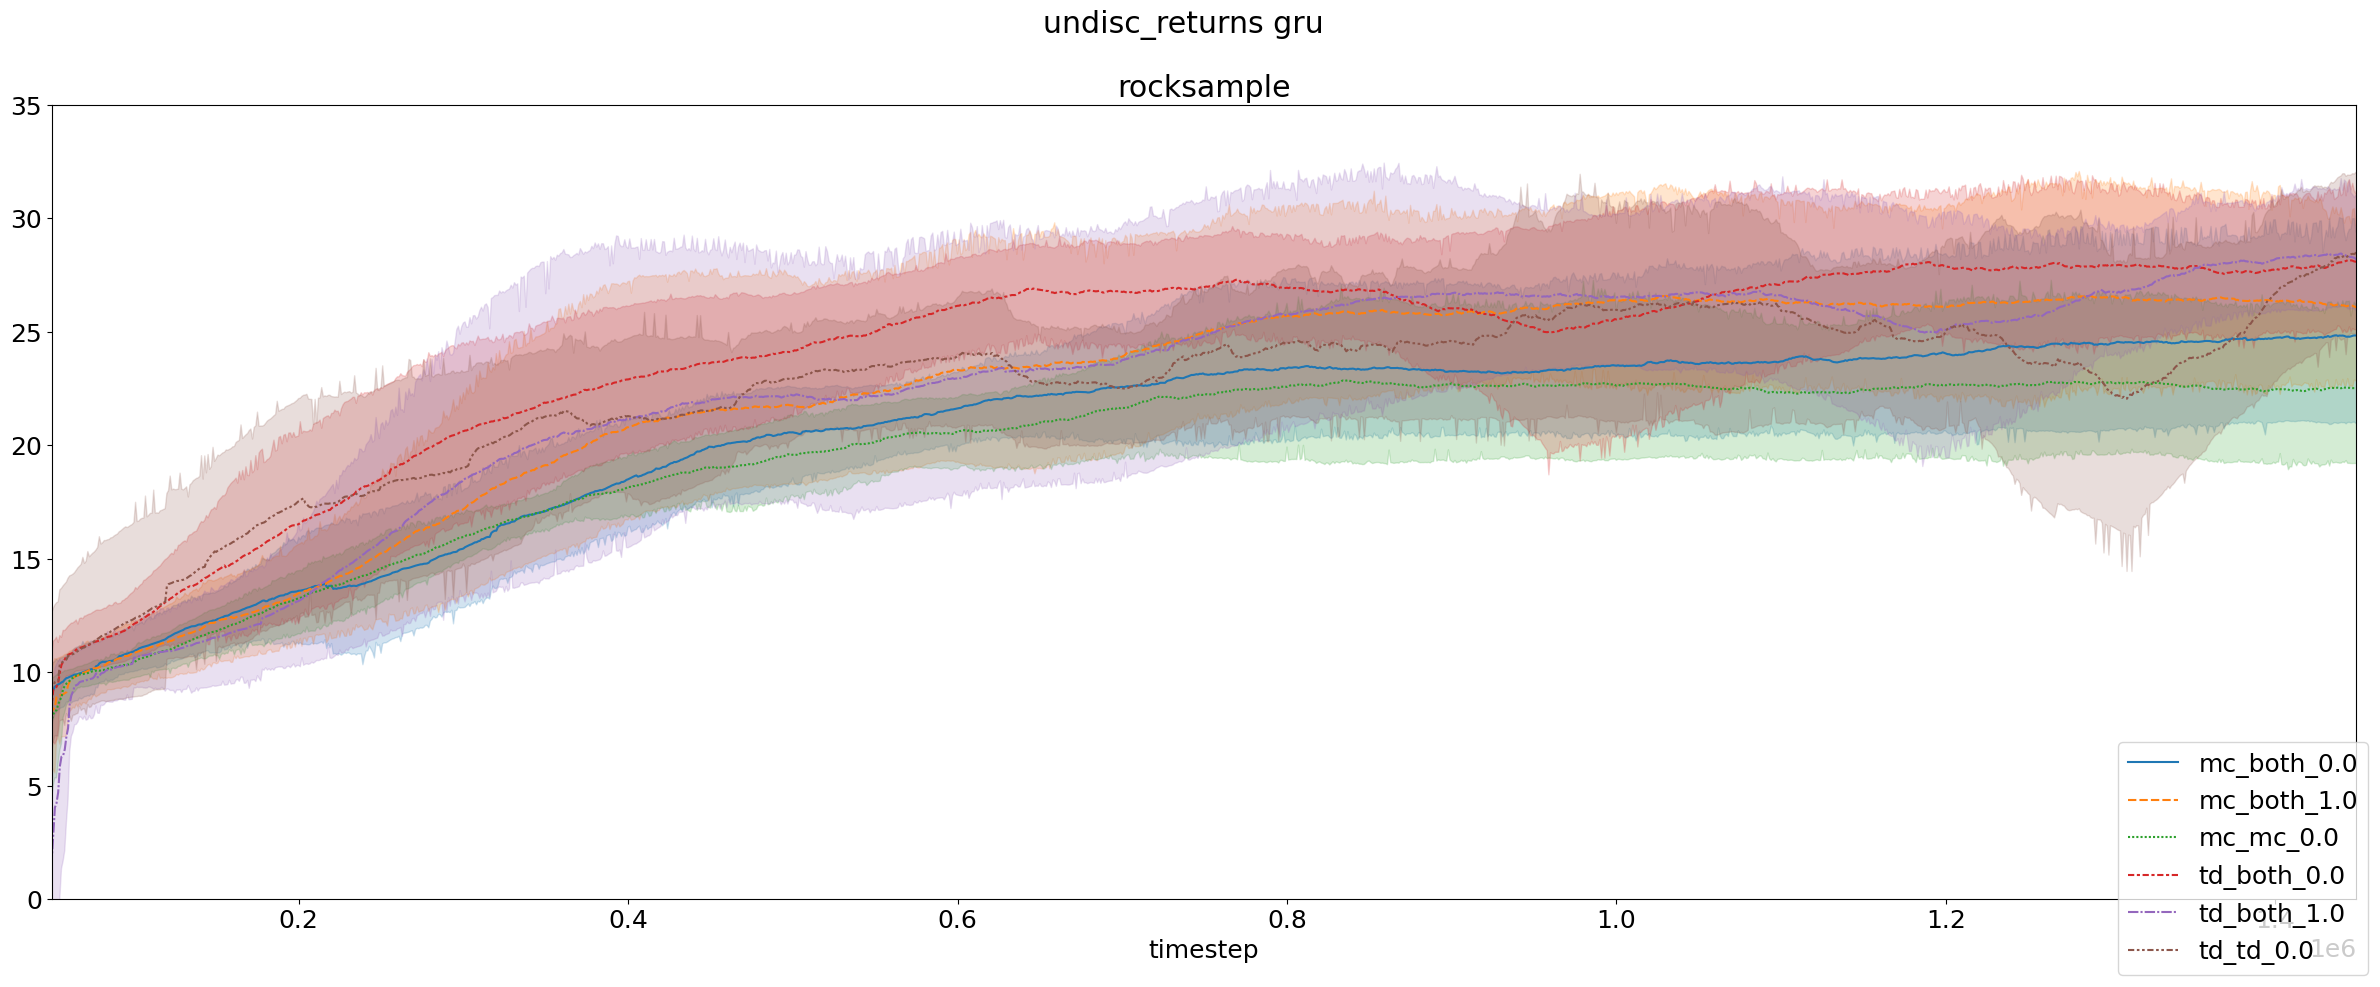

In [41]:
spec_strs = df['spec'].unique()

pivot_cols = [arg for arg in grouped_args if (arg != 'spec') and (arg != 'timestep')] + ['seed']

n_specs = len(spec_strs)

n_rows, n_cols = 2, np.ceil(n_specs / 2).astype(int)
if n_specs == 1:
    n_rows = 1

fig, axes = plt.subplots(n_rows, n_cols, figsize=(24, 10))

for i, spec in tqdm(list(enumerate(sorted(spec_strs)))):
    row = i // n_cols
    col = i % n_cols
    
    ax = axes
    if n_specs > 1:
        ax = axes[row, col]

    spec_df = df[df['spec'] == spec]
    sorted_spec_df = spec_df.sort_values(by=grouped_args)
    
    # Make a pivot table
    pivot_df = sorted_spec_df.pivot(index='timestep', columns=pivot_cols, values=pivot_value_key)
    
    # Flatten all columns except seed
    col_name = '_'.join([col for col in pivot_cols if col != 'seed'])
    multi_index = pd.MultiIndex.from_tuples([('_'.join([str(c) for c in col[:-1]]), col[-1]) for col in pivot_df.columns], names=[col_name, "seed"])

    pivot_df.columns = multi_index

    sns.lineplot(ax=ax, data=pivot_df, palette=label_cmap)
    
    ax.get_legend().remove()
    ax.set_title(spec)
    if col > 0:
        ax.set_ylabel(None)
    if row < n_rows - 1:
        ax.set_xlabel(None)
        
    handles, labels = ax.get_legend_handles_labels()
    
    if spec == 'rocksample':
        ax.set_ylim(0, 35)
        step_per_eval = 1000
        ax.set_xlim(w * step_per_eval // 2, df['timestep'].max() - w * step_per_eval // 2)
#     if i >= 1:
#         break
        
fig.legend(handles, labels, loc='lower right')
fig.suptitle(f"{measure_col} {arch}")
fig.tight_layout()

In [ ]:
# fig_path = Path(ROOT_DIR, 'results', f'{measure_col}_{arch}_rnn_td.pdf')
# fig.savefig(fig_path, bbox_inches='tight')

In [ ]:
# for results_path in tqdm(all_results_paths):
#     if results_path.is_dir() or results_path.suffix != '.npy':
#         continue
    
#     info = load_info(results_path)
#     args = info['args']
#     if args['multihead_lambda_coeff'] == -1:
#         results_path.unlink()

In [ ]:
()